<h1 style='font-size:40px'> Classification</h1>
<h2 style='font-size:30px'> Apresentação do dataset</h2>
<div>
    <ul style='font-size:20px'>
        <li>
            Neste capítulo, lidaremos com dataset MNIST, que contém 70 mil imagens de algarismos escritos à mão por estudantes do Ensino Médio americano e empregados do escritório de censos dos EUA.
        </li>
    </ul>
</div>

In [1]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)

In [2]:
# Extraindo os dados de treino e teste. Cada coluna de 'X' é a intensidade do pixel da foto do dígito. 
# Como as imagens são 28x28, temos um total de 784 pixels e colunas.
X = mnist.data
y = mnist.target.astype(int)

<h3 style='font-size:30px;font-style:italic'> Conhecendo os dados</h3>

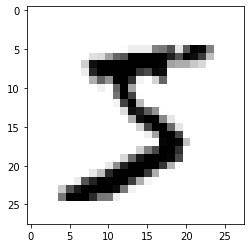

In [3]:
# Vamos analisar a imagem de um dos dígitos do dataset utilizando o matplotlib.
import matplotlib.pyplot as plt
from matplotlib.cm import binary
import numpy as np

# Obtendo os pixels do primeiro número do dataset.
some_digit_image = X.iloc[0].values.reshape(28,28)

# Tudo indica que se trata de um cinco.
plt.imshow(some_digit_image, cmap=binary, interpolation='nearest')

In [4]:
# E, de fato, o dígito em questão é um 5.
y[0]

5

<h3 style='font-size:30px;font-style:italic'> Segregação de dados</h3>
<div>
    <ul style='font-size:20px'>
        <li>
            Os dados de <em>mnist</em> já estão ordenados de maneira que as 60 mil primeiras ocorrências sejam destinadas a treino e as outras 10 mil instâncias para teste.
        </li>
    </ul>
</div>

In [5]:
# Um unpacking de tuplas será o suficiente para essa operação.
X_train, X_test, y_train, y_test = X.iloc[:60000], X.iloc[60000:], y.iloc[:60000], y.iloc[60000:]

<h2 style='font-size:30px'> Training a Binary Classifier</h2>
<div>
    <ul style='font-size:20px'>
        <li>
            Vamos começar o capítulo com uma tarefa simples: criar um classificador que identifique quando a imagem se refere a um número definido x, e quando ela não representa X. Neste caso, estamos diante de um trabalho de classificação binária.
        </li>
    </ul>
</div>

In [6]:
# O autor escolheu identificar as ocorrências de 5 e não-5.

# Os novos datasets terão valores booleanos. True para 5 e False para não-5
y_train_5 = y_train == 5
y_test_5 = y_test == 5

<div>
    <ul style='font-size:20px'>
        <li>
            Para começar a nossa tarefa, vamos utilizar o Stochastic Gradient Descent (SGD), do módulo sklearn.linear_model. Ele é bastante eficaz em lidar com datasets grandes.
        </li>
    </ul>
</div>

In [19]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

# Prevendo o valor da primeira instância de X (5). O classificador adivinha com sucesso.
sgd_clf.predict(X.iloc[0].values.reshape(1,-1))

/home/veiga/.local/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([ True])

<h2 style='font-size:30px'> Performance Measures</h2>
<div>
    <ul style='font-size:20px'>
        <li>
            Aqui, o autor faz uma breve demosntração sobre como a acurácia pode não ser a métrica de qualidade mais adequada com datasets desbalanceados.
        </li>
    </ul>
</div>

In [27]:
# Realizando uma validação cruzada cuja métrica de performance é o score do modelo. 
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5,cv=3, scoring='accuracy').mean()

0.9570333333333334

In [25]:
# Agora, vamos criar um Dummy Classifier caseiro com a classe pré-definida BaseEstimator.
# Ele sempre previrá que o número não é 5.
from sklearn.base import BaseEstimator
import numpy as np
class Never5Classifier(BaseEstimator):
    # Algo que eu havia esquecido sobre POO, podemos fazer uma classe sem um __init__.
    def fit(self, X, y=None):
        return self
    
    def predict(self, X):
        return np.zeros((len(X),1), dtype='bool' )


In [26]:
# Agora, vamos fazer uma validação cruzada com esse classificador 'burro'
never_5_clf = Never5Classifier()

# Veja, mesmo sendo dogmático, Never5Classifier tem uma taxa de acerto de quase 91%.
cross_val_score(never_5_clf, X_train, y_train_5, cv=3 ,scoring='accuracy').mean()

0.90965

<h3 style='font-size:30px;font-style:italic'> Confusion Matrix</h3>
<div>
    <ul style='font-size:20px'>
        <li>
            A matriz de confusão é uma represetação visual que contabiliza o número de classificações (certas ou erradas) feitas pelo modelo. Como apontado pelo autor, se quiséssemos saber quantas vezes o algoritmo confundiu 5 com 3, basta olharmos a terceira coluna da quinta linha da matriz. 
        </li>
    </ul>
</div>

In [30]:
# Prevendo os valores-alvo do dataset de treino com cross_val_predict
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf,X_train, y_train_5, cv=3)

In [35]:
# As linhas representam a classe verdadeira; já as colunas, a classe prevista pelo modelo.

# Nesse caso, temos mais de 50 mil valores não-5 previstos como não-5 e 3530 5's rotulados como 5.
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

<AxesSubplot:>

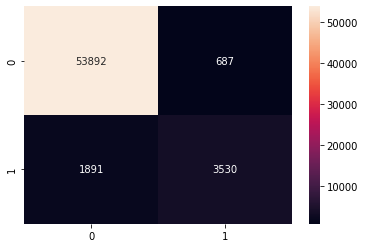

In [52]:
# Podemos utilizar um mapa de calor do seaborn para melhorar a visualização dos dados.
import seaborn as sns
sns.heatmap(confusion_matrix(y_train_5, y_train_pred), annot=True, fmt='.5g')

<div>
    <ul style='font-size:20px'>
        <li>
            A partir da matriz de confusão, podemos estimar novas métricas qualitativas sobre o modelo. Por exemplo, entre as instâncias classificadas como positivas (1), qual a porcentagem delas é realmente positiva (Precision)? Ou, de todas as instâncias positivas do dataset, qual a porcentagem delas foi que o modelo conseguiu rotular como tal (Recall)? 
        </li>
    </ul>
</div>
<center> 
    <img src='precision_recall1.png'>
</center>

<h3 style='font-size:30px;font-style:italic'> Precision and Recall</h3>

In [56]:
# Medindo as novas métricas aprendidas com o sklearn.metrics
from sklearn.metrics import recall_score, precision_score
print(f'Precisão do modelo: {precision_score(y_train_5,y_train_pred) :.2%}')
print(f'Recall do modelo: {recall_score(y_train_5,y_train_pred) :.2%}')

Precisão do modelo: 83.71%
Recall do modelo: 65.12%


<h3 style='font-size:30px;font-style:italic'> F1-Score</h3>
<div>
    <ul style='font-size:20px'>
        <li>
            O F1-Score é a média harmônica entre precision e recall. Diferentemente de uma média comum, esse índice dá um peso maior a valores pequenos.
        </li>
    </ul>
</div>

In [77]:
from sklearn.metrics import f1_score
print(f'F1-Score do modelo: {f1_score(y_train_5,y_train_pred) :.2%}')

F1-Score do modelo: 73.25%


<h3 style='font-size:30px;font-style:italic'> Precision/Recall Tradeoff</h3>
<div>
    <ul style='font-size:20px'>
        <li>
            Neste tópico, o autor discorre sobre a inevitável correlação negativa entre precision e recall. Quando queremos aumentar o valor de um dos índices, teremos que sacrificar parte do desempenho do outro.
        </li>
        <li>
            Para ilustrar como isso ocorre, é apresentada a função de pontuação da chamada <em>decision_function</em>. Os modelos de classificação aplicam essa função para cada instância a ser rotulada, o que se resulta em um número. Esse valor pode ser maior ou menor do que o threshold escolhido. Caso seja mais alto, a instância será agrupada na classe positiva; caso o contrário, na classe negativa.  
        </li>
        <li>
            O scikit-learn não nos permite ajustar esse thresolhd ao criarmos o modelo, mas podemos ajustá-lo, manualmente, com uma simples expressão comparativa. 
        </li>
    </ul>
</div>

In [98]:
# Ao invés de invocarmos 'predict', chamaremos o método 'decision_function' ao SGDClassifier.
# Qual é o valor da função de decisão na nossa instância 'some_digit_image'?
y_scores = sgd_clf.decision_function(some_digit_image.reshape(1,-1))
y_scores

/home/veiga/.local/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([2164.22030239])

In [99]:
# Definindo o threshold como 0, como o classificador rotulará a instância?
thresold = 0
y_some_digit_pred = y_scores > thresold
y_some_digit_pred

array([ True])

In [100]:
# Agora, o thresolhd será elevado a 8000. Como sera a previsão?
thresold = 8000
y_some_digit_pred = y_scores > thresold
y_some_digit_pred

array([False])

<div> 
    <ul style='font-size:20px'> 
        <li>
            Isso constata que, aumentar o thresolhd diminui o recall do modelo.
        </li>
    </ul>
</div>

In [104]:
# O 'cross_val_predict' é capaz de nos retornar a pontuação da decision function do modelo.
# Basta definirmos o 'method' como 'decision_function'.

y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')

In [107]:
# O scikit-learn têm um método capaz de nos mostrar as variações de precision conforme o thresolhd visualmente.
from sklearn.metrics import precision_recall_curve

# A função nos retorna os índices e seus respectivos thresholds.
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

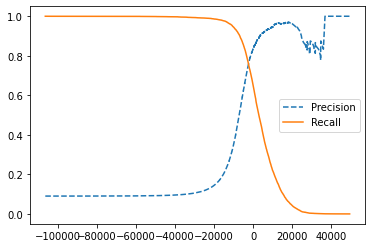

In [115]:
import matplotlib.pyplot as plt
# É comum a curva de precision sofrer pequenas quedas quando o threshold aumenta.
plt.plot(thresholds, precisions[:-1], linestyle='--', label='Precision')
plt.plot(thresholds, recalls[:-1], linestyle='-', label='Recall')
plt.legend()

Text(0, 0.5, 'Precision')

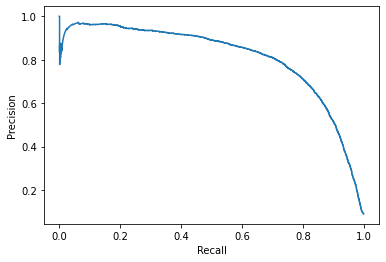

In [119]:
# Outra maneira de se plotar os dados, só que sem os thresholds.
plt.plot(recalls, precisions)
plt.xlabel('Recall')
plt.ylabel('Precision')

In [138]:
# Supondo que quiséssemos ter no mínimo 90% de precisão. Qual threshold escolher?

# np.argmax retorna o primeiro índice do valor máximo (como a condição passada entre parênteses é booleana,
# o índice será o do primeiro True que aparecer)

# Ok, o primeiro threshold que nos dará mais de 90% de precisão está na posição 57075 de 'thresolhds'.
print(np.argmax(precisions>=0.9))

threshold_90_precision = thresholds[np.argmax(precisions>0.9)]
threshold_90_precision

57075


3370.019499143957

In [144]:
# Agora, fazendo previsões usando o threshold escolhido.
y_train_pred_90 = (y_scores >= threshold_90_precision)
y_train_pred_90

array([False, False, False, ...,  True, False, False])

In [148]:
# Por questões de verificação, calculando a precision e recall dessas previsões.
print(f'Precisão: {precision_score(y_train_5, y_train_pred_90) :.2%}')
print(f'Recall: {recall_score(y_train_5, y_train_pred_90) :.2%}')

Precisão: 90.00%
Recall: 48.00%


<div> 
    <ul style='font-size:20px'> 
        <li>
            O autor nos adverte que, no entanto, não é recomendável priorizarmos precision em  prejuízo a recall. 
        </li>
    </ul>
</div>

<p style='color:red'> Continuar a partr the ROC Curve página 99</p>